In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset, MFDataset
import scipy.signal as sig


In [2]:
simul = "luckym2"

path_data = '/data0/project/vortex/lahaye/'
data_bcl = 'DIAG/NRJ_fluxes/{0}_puv_fluxes_hf.?.nc'.format(simul)
data_btr = 'DIAG/NRJ_fluxes/{0}_bt_fluxes.?.nc'.format(simul)
data_mod = '{0}_modemap/{0}_modemap.nc'.format(simul)
data_nrj = '{0}_modemap/{0}_modenrj.nc'.format(simul)

grid_file = "/net/ruchba/local/tmp/2/lahaye/prep_LUCKYTO/lucky_corgrd.nc"

dirpic = 'pictures/'
dosavefig = False

it = 300

In [3]:
# load modal energy flux and plot it (at middle of time series)
imod = 0; #slice(1,10)
rho0 = 1025.

nc = Dataset(path_data+data_nrj,'r')
times = nc.variables['time'][:]
nt = len(times)
modes = nc.variables['mode'][:]
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
fx = nc.variables['Fx_lf'][it,imod,:,:]
fy = nc.variables['Fy_lf'][it,imod,:,:]
nc.close()
print("loaded it {0}, time {1}".format(it, times[it]))

ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
dx = np.mean(1./ncgrd.variables['pm'][:,xi][eta,:])*np.diff(xi[:2])[0]
dy = np.mean(1./ncgrd.variables['pn'][:,xi][eta,:])*np.diff(eta[:2])[0]
ncgrd.close()
topo.shape

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


loaded it 300, time 300


(500, 500)

In [44]:
# compute evolution of Ctot
nc = Dataset(path_data+data_nrj,'r')
ctots = np.zeros(nt)
ctotb = np.zeros(nt)
for it in range(nt):
    fx = nc.variables['Fx_lf'][it,imod,:,:]
    fy = nc.variables['Fy_lf'][it,imod,:,:]   
    ctots[it] = -np.nansum(np.gradient(fx, dx, axis=1) + np.gradient(fy, dy, axis=0))*dx*dy/1e3
    ctotb[it] = ( np.nansum(fx[:,-1] - fx[:,0])*dy + np.nansum(fy[-1,:] - fy[0,:])*dx )/1e3
    if (it+1)%10 == 0:
        print(it, end="... ")
nc.close()
print("done! ")

timem = np.arange(nt)
plt.plot(timem, ctots, timem, -ctotb, "--")
print(ctotb[200:500].mean(), "GW")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


9... 19... 29... 39... 49... 59... 69... 79... 89... 99... 109... 119... 129... 139... 149... 159... 169... 179... 189... 199... 209... 219... 229... 239... 249... 259... 269... 279... 289... 299... 309... 319... 329... 339... 349... 359... 369... 379... 389... 399... 409... 419... 429... 439... 449... 459... 469... 479... 489... 499... 509... 519... 529... 539... 549... 559... 569... 579... 589... 599... 609... 619... 629... 639... 649... 659... 669... 679... 689... 699... 709... 719... done! 


In [4]:
# special stuff for colorbar & plotting parameters

fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in m
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol = "grey"


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=False):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)


<IPython.core.display.Javascript object>


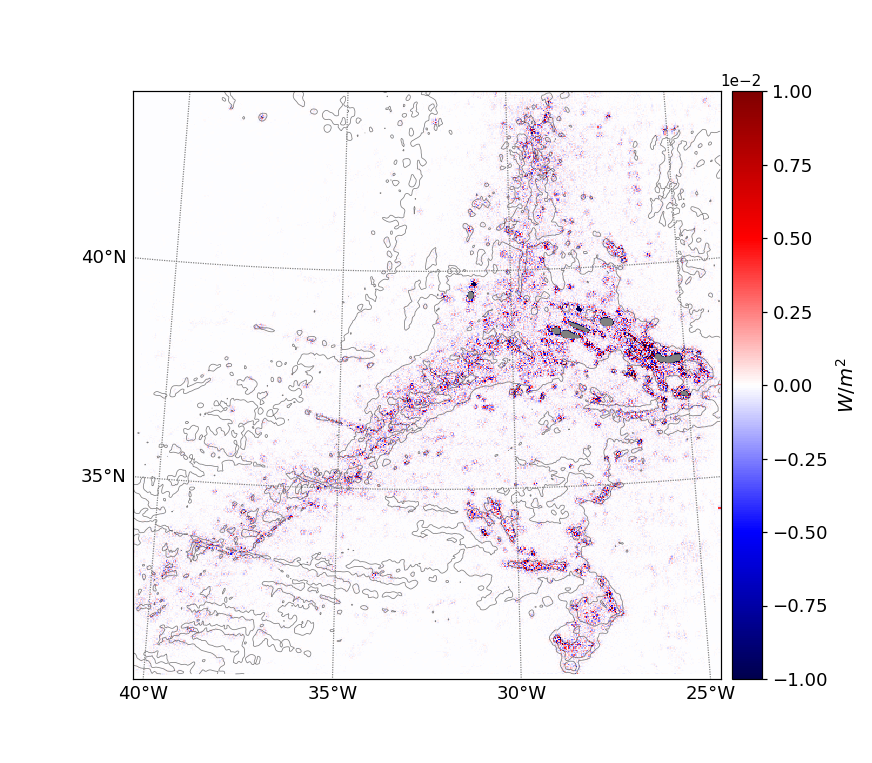

total conversion is -10.72 GW
domain averaged: -1.20 mW/m$^2$


In [5]:
toplot = -(np.gradient(fx,dx,axis=1) + np.gradient(fy,dy,axis=0)) *1e3

# plot prep
cmap = "seismic"
valmin = -0.1*1e-1
valmax = 0.1*1e-1

fig = plt.figure(figsize=(8,7))
ax = plt.gca()
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='gray')
bm.fillcontinents(color='gray')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)
hct = bm.contour(xx,yy,topo,levels=zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
for item in hct.collections:
    item.set_rasterized(True)

##### plot the data
hpc = bm.pcolormesh(xx,yy,toplot,vmin=valmin,vmax=valmax,norm=norm,cmap=cmap)
hcb = bm.colorbar(hpc)#,extend='both')

hcb.formatter.set_powerlimits((-1, 1))    
hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)

hcb.set_label(r'$W/m^2$',fontsize=fs+1)

if dosavefig:
    plt.savefig(picdir+"luckym2_Ct.png",magnification='auto',dpi=250,bbox_inches="tight")
    
# total conversion (integrated over the domain)
Ctot = np.nansum(toplot*dx*dy)
print('total conversion is {:.2f} GW'.format(Ctot/1e6))
print(r'domain averaged: {:.2f} mW/m$^2$'.format(Ctot/np.sum(dx*dy)))

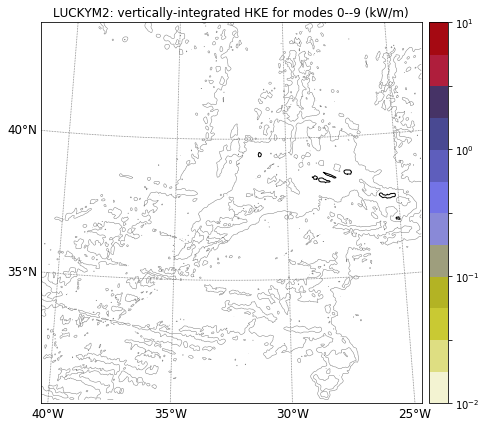

In [8]:

cmap = plt.get_cmap('gist_stern_r')
mascale = "log"

toplot = (np.gradient(Fx,dx,axis=1) \
          + np.gradient(Fy,dy,axis=0)) *1e3
#toplot = np.nansum(toplot,axis=0)*rho0

if mascale == "linear":
    valmax = 1e-3
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 1e-2
    valmax = 1e1
    levels = np.logspace(np.log10(valmin),np.log10(valmax),13)
    
### do the plot
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,topo,zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc,extend="max")
    #hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    #hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,norm = LogNorm(),linestyles=None)
    hcb = bm.colorbar(hpc)
for item in hpc.collections:
    item.set_rasterized('True')
#hpc = bm.pcolormesh(xx,yy,toplot,cmap=cmap,vmax=vmax)
#hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot.values,mask),levels,cmap=cmap,extend='max',linestyles=None)
hcb = bm.colorbar(hpc,extend="max")
#hcb.set_ticks(np.r_[0,hcb.get_ticks()])
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.formatter.set_useMathText(True)
if len(modes)>1:
    strmod = "modes {0}--{1}".format(modes[0],modes[-1])
else:
    strmod = "mode {}".format(modes[0])
plt.title(r'{0}: vertically-integrated HKE for {1} (kW/m)'.format(simul.upper(),strmod))


for item in hpc.collections:
    item.set_rasterized('True')
#hcb.ax.tick_params(labelsize=fs)
hcb.update_ticks()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


finished loading data


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1536: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


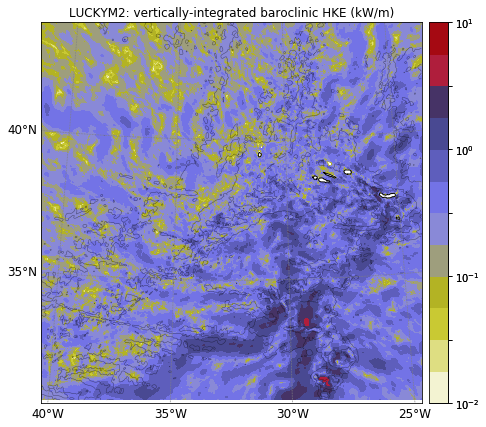

In [11]:
# load baroclinic energy flux and plot it (at middle of time series)

nc = MFDataset(path_data+data_bcl,aggdim="eta_rho")
nt= nc.dimensions['time'].size
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
lon = nc.variables['lon_rho'][:]
lat = nc.variables['lat_rho'][:]
fx = nc.variables['puint_lf'][:,:,nt//2]
fy = nc.variables['pvint_lf'][:,:,nt//2]
nc.close()
print("finished loading data")

ncgrd = Dataset(grid_file,'r')
topo = ncgrd.variables['h'][:,xi][eta,:]
ncgrd.close()
topo.shape

### plotting (from plot_Ef_SLG02)

fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in m
cmap = plt.get_cmap('gist_stern_r')
zlevs=[0,2000,3500]
topocol='k'     # isobath. contour color
grdcol = "grey"
mascale = "log"

toplot = np.sqrt(fx**2+fy**2)

if mascale == "linear":
    valmax = 1e-3
    levels = np.linspace(0,valmax,11)
    levels[0] = levels[1]/2
elif mascale == 'log':
    valmin = 1e-2
    valmax = 1e1
    levels = np.logspace(np.log10(valmin),np.log10(valmax),13)
    
### do the plot
fig = plt.figure(figsize=(8,7))
ax = plt.subplot(111)
bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly)
xx, yy = bm(lon, lat)
bm.drawcoastlines(color='black')
bm.fillcontinents(color='white')
bm.drawparallels(np.arange(-60,70,stride),labels=[1,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,1],linewidth=0.8,\
                fontsize=fs,color=grdcol)

bm.contour(xx,yy,topo,zlevs,colors=topocol,linewidths=0.5,alpha=0.5)
if mascale == 'linear':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,extend='max',linestyles=None)
    hcb = bm.colorbar(hpc,extend="max")
    #hcb.set_ticks(np.r_[0,hcb.get_ticks()])
    hcb.formatter.set_powerlimits((-1, 1))
    #hcb.formatter.set_useMathText(True)
    hcb.update_ticks()
elif mascale == 'log':
    hpc = bm.contourf(xx,yy,toplot,levels,cmap=cmap,norm = LogNorm(),linestyles=None)
    hcb = bm.colorbar(hpc)
for item in hpc.collections:
    item.set_rasterized('True')
#hpc = bm.pcolormesh(xx,yy,toplot,cmap=cmap,vmax=vmax)
#hpc = bm.contourf(xx,yy,np.ma.masked_array(toplot.values,mask),levels,cmap=cmap,extend='max',linestyles=None)
hcb = bm.colorbar(hpc,extend="max")
#hcb.set_ticks(np.r_[0,hcb.get_ticks()])
#hcb.formatter.set_powerlimits((-1, 1))
#hcb.formatter.set_useMathText(True)
plt.title(r'{0}: vertically-integrated baroclinic HKE (kW/m)'.format(simul.upper()))


for item in hpc.collections:
    item.set_rasterized('True')
#hcb.ax.tick_params(labelsize=fs)
hcb.update_ticks()

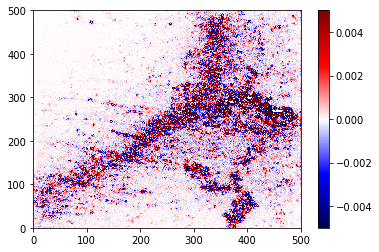

In [10]:
valabs = 5e-2
plt.pcolormesh(toplot,cmap="seismic",vmax=valabs,vmin=-valabs); 
plt.colorbar()

print("total=",np.nansum(toplot*dx*dy))